# 1. Vision Transformer - архитектура и сравнение с CNN
https://arxiv.org/pdf/2010.11929
![](../images/2020_ImageIsWorth16x16Words_FIG1.png)

| **Характеристика**                        | **ViT**                                                              | **CNN**                 |
| ---                                      | ---                                                              | ---                 |
| Как обрабатывается изображение?          | Последовательность патчей (токенов)                              | Сверточные ядра дают карты активации |
| Обработка локальных признаков            | В базе - хуже, чем CNN (используется FFN)  | Отлично |
| Обработка глобальных признаков           | Отлично (за счёт self-attention)           | Обычно хуже (свертки менее гибки глобально) |
| Вычислительные ресурсы                   | Требует много ресурсов (возможны оптимизации) | Свертки сами по себе работают быстро | 
| Чувствительность к размеру данных        | Требуют больших наборов данных для хорошей генерализации  | Эффективны даже на малых объемах данных |
| Интерпретируемость          | Карты внимания хорошо интерпретируемы | Сложна для нижних слоёв сверток |

Также отметим, что только трансформерные архитектуры дают гибкую и масштабируемую мультимодальность (т.е. могут работать с токенами, представляющими разные типы данных), чего нет в других архитектурах.


 # Пишем Vision Transformer с нуля

In [1]:
import math
from typing import Tuple, List, Dict, Sized, Optional, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L

import numpy

import seaborn as sns
import matplotlib.pyplot as plt

/var/home/alexey/.conda/envs/nn_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 ## 1.1. Токенизация и эмбеддинги изображений



 Мы начнём сразу с комбинированной ViT-CNN архитектуры, просто потому что это проще и эффективнее - применение `Conv2d` с `kernel_size` = `stride` позволяет сразу сделать и токенизацию, и векторное вложение изображения.

In [2]:
class PatchEmbedding(nn.Module):

    def __init__(self, patch_size: int, channels: int, emb_dim: int):
        '''
        :param patch_size: int - size of the patch square (size of convolution kernel)
        :param channels: int - channels of input image
        :param emb_dim: int - embedding dimension
        '''
        super().__init__()
        self.patch_size = patch_size
        self.conv = nn.Conv2d(
            in_channels=channels,
            out_channels=emb_dim,
            kernel_size=patch_size,
            stride=patch_size,
            )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        :param x: torch.Tensor [B, C, H, W] - batched images
        :returns: torch.Tensor [B, D, pH, pW] - patches embeddings
        '''
        return self.conv(x)        


In [3]:
# Проверим:

patch_size = 4
in_channels = 3
emb_dim = 64

img_W = 32
img_H = 32

test_emb = PatchEmbedding(patch_size=patch_size, channels=in_channels, emb_dim=emb_dim)
x = torch.randn(1, in_channels, img_W, img_H)
y = test_emb(x)

print(y.shape)
print(y)

torch.Size([1, 64, 8, 8])
tensor([[[[-0.8309, -0.5106, -0.5376,  ..., -0.0421, -0.0341, -0.0661],
          [-0.0537,  0.1545, -0.4661,  ...,  0.1210, -0.4980, -0.2738],
          [-1.1152,  0.4051, -0.1983,  ...,  0.5230, -0.1204, -1.2992],
          ...,
          [-0.6923,  0.1672, -0.4338,  ..., -0.2806,  1.1269, -0.2973],
          [ 0.3771,  0.0374,  0.2987,  ..., -0.2632,  0.4573,  0.0760],
          [-0.1502, -0.5779, -0.3707,  ..., -0.3065, -0.3857,  0.0084]],

         [[-0.5425,  0.8092, -0.1607,  ..., -0.2698, -0.8646, -0.1893],
          [-0.0417, -0.6224, -0.4495,  ..., -0.2622,  1.6669, -0.2566],
          [ 0.3817, -0.1224, -0.0939,  ..., -0.3497,  0.2766,  0.4008],
          ...,
          [ 0.0297, -0.2801, -0.0392,  ...,  0.4201, -0.0604, -0.2928],
          [-0.4188, -0.5527,  0.0800,  ...,  0.6297, -0.1410,  0.5590],
          [ 0.5601,  0.2617,  0.0895,  ...,  0.6799,  0.1963,  0.6854]],

         [[-0.2389,  0.3268,  1.0364,  ...,  0.1922, -0.1231,  0.0218],
    

In [6]:
# Позиционное кодирование:

class SinusoidalEncoding(nn.Module):

    def __init__(self, emb_dim: int, max_len: int, freezed=True):
        '''
        :param emb_dim: int - embedding dimension
        :param max_len: int - maximum length of sequence
        :param freezed: bool - freeze parameters
        '''
        super().__init__()
        self.emb_dim = emb_dim
        self.norm = 1/math.sqrt(emb_dim)
        self.max_len = max_len
        position = torch.arange(max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * -(4*math.log(10.0) / emb_dim))
        
        pe = torch.zeros(max_len, emb_dim)
        pe[:, 0::2] = torch.sin(position * div_term)  
        pe[:, 1::2] = torch.cos(position * div_term)  
        self.pe = nn.Parameter(pe*self.norm, requires_grad=freezed)

    def forward(self, x: torch.Tensor, pos: Optional[torch.Tensor]=None) -> torch.Tensor:
        '''
        :param x: input sequence [B, L, D]
        :param pos: positions [B, L]
        :returns x: output sequence [B, L, D]
        '''
        batch_size, seq_len, _ = x.shape
        if pos is None:
            pos = torch.arange(0, seq_len)

        return x + self.pe[pos, :]

class SinusoidalEncodingXY(nn.Module):

    def __init__(self, emb_dim: int, max_patches_xy: int = 128, freezed=True, separate=True):
        '''
        :param emb_dim: 
        :param max_patches_xy:
        :param freezed:
        :param separate: 
        '''
        super(SinusoidalEncodingXY, self).__init__()
        assert emb_dim % 4 == 0, f'Embedding dimension must be divisible by 4'
        assert emb_dim > 4, f'Embedding dimension must be greater than 4'
        self.emb_dim = emb_dim
        self.ax_emb_dim = emb_dim
        self.separate = separate
        if separate: self.ax_emb_dim = self.ax_emb_dim // 2
        self.h_emb = SinusoidalEncoding(self.ax_emb_dim, max_patches_xy, freezed)
        self.w_emb = SinusoidalEncoding(self.ax_emb_dim, max_patches_xy, freezed)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        :param x: input patches [B, D, H, W]
        :returns: output sequence [B, L, D]
        '''
        batch_size, emb_dim, patch_h, patch_w = x.shape
        
        outp = x.flatten(-2).swapaxes(-1, -2)
        h_, w_ = torch.arange(patch_h, dtype=torch.int32), torch.arange(patch_w, dtype=torch.int32)
        h_pos, w_pos = torch.meshgrid(h_, w_, indexing='ij')
        h_pos = h_pos.flatten().unsqueeze(0)
        w_pos = w_pos.flatten().unsqueeze(0)

        if self.separate:
            outp[:, :, :self.ax_emb_dim] = self.h_emb(outp[:, :, :self.ax_emb_dim], h_pos)
            outp[:, :, self.ax_emb_dim:] = self.w_emb(outp[:, :, self.ax_emb_dim:], w_pos)
        else:
            outp = self.h_emb(outp, h_pos)
            outp = self.w_emb(outp, w_pos)
            
        return outp

def visualize_hw_encodings(input_patches: torch.Tensor, selected_ij: Tuple[int, int], encoding: SinusoidalEncoding):  

    batch, emb_dim, p_H, p_W = input_patches.shape
    i, j = selected_ij
    enc = encoding.forward(input_patches)[0, ...] # get rid of batch dimension
    selected_enc = enc[i*p_W + j, :] 

    # Calculate dot products
    dot_products = enc @ selected_enc  # Shape: (num_patches,)

    # Reshape for visualization
    heatmap_data = dot_products.view(p_H, p_W).detach().numpy()    
    plt.figure(figsize=(p_W+2, p_H+2))

    fig, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(heatmap_data, cmap=cmap,  square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

    # sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='viridis')
    plt.title(f'Heatmap of Dot Products for Patch ({i}, {j})')
    plt.xlabel('Patch W')
    plt.ylabel('Patch H')
    plt.show()


torch.Size([1, 192, 128])


<Figure size 1800x1400 with 0 Axes>

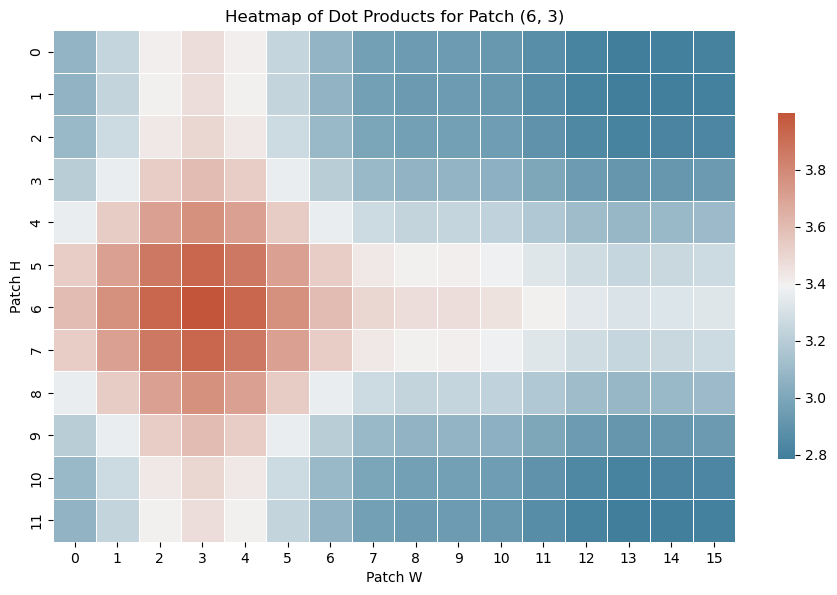

In [7]:
patch_size = 4
in_channels = 3
emb_dim = 128
p_H, p_W = 12, 16

x = torch.zeros(1, emb_dim, p_H, p_W)

pos_enc = SinusoidalEncodingXY(emb_dim, separate=True)

y = pos_enc(x)
print(y.shape)

visualize_hw_encodings(x, (6, 3), pos_enc)
plt.show()


In [8]:
# Соберем все вместе

class ImageEmbedding(nn.Module):

    def __init__(self, patch_size: int, in_channels: int, emb_dim: int, dropout_rate: float = 0.1, freezed_pe = True):
        '''
        :param patch_size: int - size of the square patch
        :param in_channels: int - number of input channels
        :param emb_dim: int - embedding dimension
        :param dropout_rate: float - dropout rate
        :param freezed_pe: bool - freeze positional embeddings
        '''
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.emb_dim = emb_dim
        self.dropout_rate = dropout_rate
        self.freezed_pe = freezed_pe

        self.dropout = nn.Dropout(dropout_rate)
        self.img_emb = PatchEmbedding(patch_size=patch_size, channels=in_channels, emb_dim=emb_dim)
        
        self.pos_emb = SinusoidalEncodingXY(emb_dim=emb_dim, max_patches_xy=emb_dim//2, freezed=freezed_pe)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        :param x: torch.Tensor [B, C, H, W] - input image
        :returns: torch.Tensor [B, L, D] - output tokens (L=H*W//patch^2)
        '''
        x_patches = self.img_emb(x) # [B, D, pH, pW]

        return self.pos_emb(x_patches) # SinusoidalEncodingXY expects [B, D, pH, pW]


In [9]:
batch_size = 1
patch_size = 16
in_channels = 3
emb_dim = 64

img_H, img_W = 224, 224

x = torch.zeros(batch_size, in_channels, img_H, img_W)

im2seq = ImageEmbedding(patch_size=patch_size, in_channels=in_channels, emb_dim=emb_dim)

y = im2seq(x)

print(y.shape)

torch.Size([1, 196, 64])


In [10]:
# Сравним объём информации до и после вложения
print(f'Image size (in elements): {x.numel():e}')
print(f'Image embedding size (in elements): {y.numel():e}')

print(f'Image size (in bytes): {x.numel():e}')
print(f'Image embedding size (in bytes): {y.numel()*y.element_size():e}')

Image size (in elements): 1.505280e+05
Image embedding size (in elements): 1.254400e+04
Image size (in bytes): 1.505280e+05
Image embedding size (in bytes): 5.017600e+04


  ## 1.2. Модель

  ![](../images/CLS_token.webp)

In [14]:
import lightning as L
import torchmetrics

class ImageClassifier(L.LightningModule):

    def __init__(
            self, 
            n_classes: int, 
            in_channels: int,
            patch_size: int, 
            emb_dim: int, 
            n_layers: int, 
            MHAnheads: int, 
            ff_dim: int, 
            dropout_rate: float, 
            freeze_pe: bool=True,
            ):
        '''
        :param n_classes: int - number of classes 
        :param in_channels: int - number of input channels
        :param patch_size: int - size of the square patch
        :param emb_dim: int - embedding dimension
        :param n_layers: int - number of layers
        :param MHAnheads: int - number of multihead attention heads
        :param ff_dim: int - hidden size of feedforward network in transformer
        :param dropout_rate: float - dropout rate
        '''
        super().__init__()
        self.save_hyperparameters()

        # YOUR CODE
        self.embedding = ImageEmbedding(
            patch_size=patch_size, in_channels=in_channels, emb_dim=emb_dim, 
            dropout_rate=dropout_rate, freezed_pe=freeze_pe
            )
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=MHAnheads,
            dim_feedforward=ff_dim, dropout=dropout_rate,
            norm_first=True, batch_first=True,
            )

        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=n_layers)
        
        self.proj = nn.Linear(emb_dim, n_classes)

        self.CLS_token = nn.Parameter(torch.randn(emb_dim), requires_grad=False)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        :param x: torch.Tensor [B, C, H, W] - input image        
        :returns: torch.Tensor [B, N_CLS]

        '''
        # YOUR CODE
        batch_size = x.shape[0]
        x_emb: torch.Tensor = self.embedding.forward(x)
        x_cls = self.CLS_token.view(1, 1, -1).repeat(batch_size, 1, 1)
        x_emb = torch.cat((x_emb, x_cls), dim=1)

        x_enc = self.encoder.forward(x_emb)
        x_cls = x_enc[:, -1, :]

        probs = F.log_softmax(self.proj(x_cls), dim=-1)

        return probs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

    def training_step(self, batch, batch_id: int):
        x, y = batch
        logits = self.forward(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_id: int):
        x, y = batch
        logits = self.forward(x)
        loss = F.nll_loss(logits, y)
        self.log("val_loss", loss)
        preds = torch.argmax(logits, dim=1)
        self.accuracy.update(preds, y)
        self.log("val_acc", self.accuracy, on_epoch=True, on_step=False)
        return loss

    def test_step(self, batch, batch_id: int):
        x, y = batch
        logits = self.forward(x)
        loss = F.nll_loss(logits, y)
        self.log("test_loss", loss)
        preds = torch.argmax(logits, dim=1)
        self.accuracy.update(preds, y)
        self.log("test_acc", self.accuracy, on_epoch=True, on_step=False)
        return loss


In [16]:
batch_size = 1
patch_size = 16
in_channels = 3
emb_dim = 64

img_H, img_W = 224, 224

x = torch.zeros(batch_size, in_channels, img_H, img_W)

model = ImageClassifier(10, in_channels, patch_size, emb_dim, 4, 4, 512, 0.1 )
preds = model(x)

preds.shape

/var/home/alexey/.conda/envs/nn_env/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


torch.Size([1, 10])

 # CIFAR-10

![](../images/cifar10_classes.png)

 Применим реализованную архитектуру для предсказания классов в датасете CIFAR-10

In [ ]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset

import pandas as pd
from PIL import Image
from typing import Dict, List, Optional

class CIFAR10Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.transform = transform
        self.load_and_preprocess_images(df)

    def load_and_preprocess_images(self, df: pd.DataFrame):
        """Load and preprocess images once during initialization."""
        images = []
        labels = []
        
        for idx in range(len(self.df)):
            row = self.df.iloc[idx]
            img = Image.fromarray(row['image']).convert('RGB')
            label = row['label']

            if self.transform is not None:
                img = self.transform(img)

            images.append(img)
            labels.append(label)

        self.images = images
        self.labels = labels
    
    def __len__(self):

        return len(self.images)
    
    def __getitem__(self, idx) -> Tuple[torch.Tensor, int]:

        return self.images[idx], self.labels[idx]

    def get_loaders(
            self,
            names: Optional[List[str]] = ['train', 'val'],
            ratios: Optional[List[float]] = [0.9, 0.1],
            shuffle: Optional[List[bool]] = [True, False],
            batch_size: int = 8,
            load_ratio: int = 1.0,
            **kwargs,
        ) -> Dict[str, DataLoader]:
        """
        Fetches several dataloaders from this dataset
        """ 

        indices = list(range(len(self)))
        i0 = 0
        dataloaders: Dict[str, DataLoader] = {}
        
        for name, part, shuff in zip(names, ratios, shuffle):
            part_len = int(len(indices) * part * load_ratio )
            subset = Subset(self, indices[i0: i0 + part_len])
            dataloaders[name] = DataLoader(subset, batch_size, shuff, **kwargs)
            i0 += part_len        
            
        return dataloaders

    def loader(self, batch_size: int = 8, shuffle: bool =True, load_ratio: float = 1.0, **kwargs):
        
        indices = list(range(len(self)))
        subset = Subset(self, indices[: int(len(indices)*load_ratio)])
        return DataLoader(subset, batch_size, shuffle, **kwargs)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(dataset, num_images=10):
    """Displays a grid of images from the dataset."""
    plt.figure(figsize=(15, 8))
    
    for i in range(num_images):
        img, label = dataset[i]
        img = np.transpose(img.numpy(), (1, 2, 0)) 
        
        img = (img * 0.5 + 0.5)  
        plt.subplot(2, 5, i + 1) 
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')  #
        
df_test = pd.read_parquet('../data/cifar10_test.parquet')


In [ ]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
import pandas as pd
from PIL import Image

class CIFAR10Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Assuming 'image' column contains numpy array representation of image
        img = Image.fromarray(row['image']).convert('RGB')
        label = row['label']

        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def get_loaders(
            self,
            names: Optional[List[str]] = ['train', 'val'],
            ratios: Optional[List[float]] = [0.9, 0.1],
            shuffle: Optional[List[bool]] = [True, False],
            batch_size: int = 8,
            load_ratio: int = 1.0,
            **kwargs,
        ) -> Dict[str, DataLoader]:
        """
        Fetches several dataloaders from this dataset
        """
        indices = list(range(len(self)))
        i0 = 0
        dataloaders: Dict[str, DataLoader] = {}
        
        for name, part, shuff in zip(names, ratios, shuffle):
            part_len = int(len(indices) * part * load_ratio )
            subset = Subset(self, indices[i0: i0 + part_len])
            dataloaders[name] = DataLoader(subset, batch_size, shuff, collate_fn=self.collate_fn, **kwargs)
            i0 += part_len        
            
        return dataloaders


In [ ]:
import optuna
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

df_train = pd.read_parquet("../data/cifar10_train.parquet")
df_test = pd.read_parquet("../data/cifar10_test.parquet")

def objective(trial: optuna.Trial):

    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    emb_dim = trial.suggest_categorical("emb_dim", [64, 128, 256])
    n_layers = trial.suggest_int("n_layers", 2, 6)
    MHAnheads = trial.suggest_categorical("MHAnheads", [4, 8])
    ff_dim = trial.suggest_categorical("ff_dim", [emb_dim * 2, emb_dim * 4])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)

    model = ImageClassifier(
        n_classes=10,
        in_channels=3,
        patch_size=8,
        emb_dim=emb_dim,
        n_layers=n_layers,
        MHAnheads=MHAnheads,
        ff_dim=ff_dim,
        dropout_rate=dropout_rate,
    )
    
    model.hparams.lr = lr

    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    logger = TensorBoardLogger("optuna_logs", name="vit_cifar10")

    trainer = Trainer(
        max_epochs=10, 
        accelerator="auto",
        devices=1,
        logger=logger,
        callbacks=[lr_monitor],
        enable_progress_bar=True, 
    )

    trainer.fit(model, train_dataloaders=None, val_dataloaders=None)

    return trainer.callback_metrics["val_acc"].item()

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=5) 

    print("Number of finished trials:", len(study.trials))
    print("Best trial:", study.best_trial.params)
    print("Best value:", study.best_value)
